In [1]:
import os
from random import choices

from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch, torchvision
from PIL import Image
import matplotlib.pyplot as plt

from utils_nn import RandomNDataset, AllDataDataset, init_train_transform, init_val_transform
from utils_nn import init_gray_train_transform, init_gray_val_transform

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_transform = init_train_transform()
val_transform = init_val_transform()

gray_train_transform = init_gray_train_transform()
gray_val_transform = init_gray_val_transform()

In [4]:
train_path = "data/train"
val_path = "data/val"

In [5]:
# batch_size = 128

# train_dataset = AllDataDataset(train_path, train_transform, n_images=45000) 
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

# val_dataset = AllDataDataset(val_path, val_transform, n_images=15000) 
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

In [6]:
batch_size = 128

train_dataset = RandomNDataset(train_path, gray_train_transform, n_images=20000) 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = RandomNDataset(val_path, gray_val_transform, n_images=5000) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 


In [7]:
resnet18 = torchvision.models.resnet18(pretrained=True)

# for param in resnet18.parameters():
#     param.requires_grad = False

# Changing the last fc to 4 output features
# resnet18.fc = torch.nn.Sequential(torch.nn.Linear(512, 64), torch.nn.Linear(64, 4))
resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet18.fc = torch.nn.Linear(512, 1)
resnet18 = resnet18.to(device)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-6)

c:\Users\KachnovVA\Desktop\test\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KachnovVA\Desktop\test\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train(epochs):
    print("Starting training..")
    train_loss_list = []
    val_loss_list = []
    best_val_loss = 10000
    for e in range(0, epochs):
        print("=" * 20)
        print(f"Starting epoch {e + 1}/{epochs}")
        print("=" * 20)

        if e % 10 == 0 and e != 0:
            train_dataloader.dataset.new_data()
            val_dataloader.dataset.new_data()

        train_loss = 0.0
        val_loss = 0.0  # Not computing val_loss since we'll be evaluating the model multiple times within one epoch

        resnet18.train()  # set model to training phase

        for train_step, (images, val) in enumerate(train_dataloader):

            images = images.to(device)
            val = val.to(device)

            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = criterion(outputs, val)
            # Once we get the loss we need to take a gradient step
            loss.backward()  # Back propagation
            optimizer.step()  # Completes the gradient step by updating all the parameter values (we are using all parameters)
            train_loss += (
                loss.item()
            )  # Loss is a tensor which can't be added to train_loss so .item() converts it to float

            # Evaluating the model every 20th step
            if train_step % 20 == 0:
                print("Evaluating at step", train_step)
                val_loss = 0.0

                resnet18.eval()  # set model to eval phase

                for val_step, (images, val) in enumerate(val_dataloader):

                    images = images.to(device)
                    val = val.to(device)

                    with torch.no_grad():
                        outputs = resnet18(images)

                    loss = criterion(outputs, val)
                    val_loss += loss.item()

                val_loss /= val_step + 1
                print(f"Validation Loss: {val_loss:.4f}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_loss_weights = resnet18.state_dict()

                resnet18.train()

        train_loss /= train_step + 1

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Training Loss: {train_loss:.4f}")
    print("Training complete..")
    last_loss_weights = resnet18.state_dict()

    return last_loss_weights, best_loss_weights, train_loss_list, val_loss_list

Starting training..
Starting epoch 1/100


c:\Users\KachnovVA\Desktop\test\.conda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating at step 0


c:\Users\KachnovVA\Desktop\test\.conda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validation Loss: 0.3228
Evaluating at step 20
Validation Loss: 0.1700
Evaluating at step 40
Validation Loss: 0.1760
Evaluating at step 60
Validation Loss: 0.1602
Evaluating at step 80
Validation Loss: 0.1605
Evaluating at step 100
Validation Loss: 0.1575
Evaluating at step 120
Validation Loss: 0.1554
Evaluating at step 140
Validation Loss: 0.1534


c:\Users\KachnovVA\Desktop\test\.conda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss: 0.1320
Starting epoch 2/100
Evaluating at step 0
Validation Loss: 0.1525
Evaluating at step 20
Validation Loss: 0.1510
Evaluating at step 40
Validation Loss: 0.1497
Evaluating at step 60
Validation Loss: 0.1483
Evaluating at step 80
Validation Loss: 0.1477
Evaluating at step 100
Validation Loss: 0.1466
Evaluating at step 120
Validation Loss: 0.1467
Evaluating at step 140
Validation Loss: 0.1447
Training Loss: 0.1124
Starting epoch 3/100
Evaluating at step 0
Validation Loss: 0.1436
Evaluating at step 20
Validation Loss: 0.1421
Evaluating at step 40
Validation Loss: 0.1423
Evaluating at step 60
Validation Loss: 0.1419
Evaluating at step 80
Validation Loss: 0.1413
Evaluating at step 100
Validation Loss: 0.1400
Evaluating at step 120
Validation Loss: 0.1404
Evaluating at step 140
Validation Loss: 0.1393
Training Loss: 0.1091
Starting epoch 4/100
Evaluating at step 0
Validation Loss: 0.1384
Evaluating at step 20
Validation Loss: 0.1378
Evaluating at step 40
Validation Loss: 0

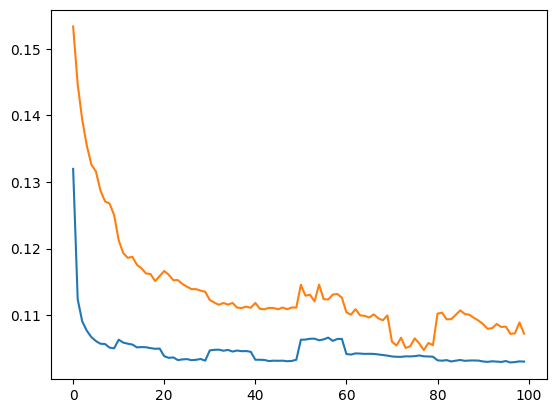

In [9]:
epoch_n = 100
exp_name = "gray_ep_100_angle_new_data_lr_6"

last_loss_weights, best_loss_weights, train_loss_list, val_loss_list = train(epochs=epoch_n)

save_path = os.path.join("weights", exp_name)
try: 
    os.mkdir(save_path)
except: 
    pass

torch.save(last_loss_weights, save_path+"/last.pth")
torch.save(last_loss_weights, save_path+"/best.pth")
np.save(save_path+"/train_loss.npy", train_loss_list)
np.save(save_path+"/val_loss.npy", val_loss_list)

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.show()

In [11]:
# def train(epochs):
#     print('Starting training..')
#     for e in range(0, epochs):
#         print('='*20)
#         print(f'Starting epoch {e + 1}/{epochs}')
#         print('='*20)

#         train_loss = 0.
#         val_loss = 0.  # Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        
#         resnet18.train() # set model to training phase
        
#         for train_step, (images, val) in enumerate(train_dataloader):
            
#             images = images.to(device)
#             val = val.to(device)
            
#             optimizer.zero_grad()
#             outputs = resnet18(images)
#             loss = criterion(outputs, val)
#             # Once we get the loss we need to take a gradient step
#             loss.backward() # Back propagation
#             optimizer.step() # Completes the gradient step by updating all the parameter values (we are using all parameters)
#             train_loss += loss.item() # Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
#             # Evaluating the model every 20th step
#             if train_step % 20 == 0:
#                 print('Evaluating at step', train_step)

#                 accuracy = 0

#                 resnet18.eval() # set model to eval phase

#                 for val_step, (images, val) in enumerate(val_dataloader):
                    
#                     images = images.to(device)
#                     val = val.to(device)
                    
#                     with torch.no_grad():
#                         outputs = resnet18(images)
                        
#                     loss = criterion(outputs, val)
#                     val_loss += loss.item()

#                     _, preds = torch.max(outputs, 1)
#                     accuracy += sum((preds.cpu() == val.cpu()).numpy()) # adding correct preds to acc

#                 val_loss /= (val_step + 1)
#                 accuracy = accuracy/len(val_dataset)
#                 print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

#                 resnet18.train()

#                 # if accuracy >= 0.85:
#                 if accuracy >= 0.9:
#                     print('Performance condition satisfied, stopping..')
#                     return

#         train_loss /= (train_step + 1)

#         print(f'Training Loss: {train_loss:.4f}')
#     print('Training complete..')